<a href="https://colab.research.google.com/github/DoHanChoi/EEG-/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%ED%8C%80%ED%94%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade scipy

In [ ]:
!pip install optuna

In [ ]:
# 데이터 로드
train_data = np.load('//content//drive//MyDrive//train.npy', allow_pickle=True).item()
test_data = np.load('//content//drive//MyDrive//test.npy', allow_pickle=True).item()

# 훈련 데이터와 레이블 추출
X_train = train_data['input']
y_train = train_data['label']

# 2차원 행렬로 재구성
X_train = X_train.reshape(X_train.shape[0], -1)

In [ ]:
import numpy as np

# 데이터 로드
train_data = np.load('/content/drive/MyDrive/train.npy', allow_pickle=True).item()
test_data = np.load('/content/drive/MyDrive/test.npy', allow_pickle=True).item()

# 로드된 데이터의 키 확인
print("Train data keys:", train_data.keys())
print("Test data keys:", test_data.keys())

# 입력 데이터와 레이블의 형태 확인
print("Shape of train input:", train_data['input'].shape)
print("Shape of train labels:", train_data['label'].shape)
print("Shape of test input:", test_data['input'].shape)

Train data keys: dict_keys(['input', 'label'])
Test data keys: dict_keys(['input'])
Shape of train input: (1080, 256, 64, 1)
Shape of train labels: (1080,)
Shape of test input: (120, 256, 64, 1)


In [ ]:
!pip install mne

In [ ]:
pip install numpy mne scipy

In [ ]:
import numpy as np
import mne
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=10):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=1)
    return y

# 데이터 로드
train_data = np.load('/content/drive/MyDrive/train.npy', allow_pickle=True).item()
input_data = train_data['input']
fs = 256  # 샘플링 주파수, 데이터에 맞게 조정 필요

# 공통 평균 참조 (CAR) 적용
input_mean = np.mean(input_data, axis=1, keepdims=True)
ref_data = input_data - input_mean

# 필터링 적용
lowcut = 0.5  # 저주파 차단 (Hz)
highcut = 30  # 고주파 차단 (Hz)
filtered_data = butter_bandpass_filter(ref_data, lowcut, highcut, fs, order=6)

print("필터링된 데이터의 형태:", filtered_data.shape)


필터링된 데이터의 형태: (1080, 256, 64, 1)


In [ ]:
import numpy as np

def remove_baseline(data, baseline_window):
    """
    Remove the baseline from the data using the mean of the specified baseline window.

    Parameters:
        data (numpy.ndarray): Input data array.
        baseline_window (tuple): Start and end indices for the baseline period.

    Returns:
        numpy.ndarray: Data with baseline removed.
    """
    baseline = np.mean(data[:, baseline_window[0]:baseline_window[1], :, :], axis=1, keepdims=True)
    return data - baseline

def segment_data(data, segment_window):
    """
    Segment the data to the specified window.

    Parameters:
        data (numpy.ndarray): Data from which to extract segments.
        segment_window (tuple): Start and end indices for the segmentation period.

    Returns:
        numpy.ndarray: Segmented data.
    """
    return data[:, segment_window[0]:segment_window[1], :, :]

# Parameters
fs = 256  # Sampling frequency
baseline_start_ms = 0  # Start of the baseline in milliseconds
baseline_end_ms = 100  # End of the baseline in milliseconds
segment_start_ms = 100  # Start of the segment in milliseconds
segment_end_ms = 800  # End of the segment in milliseconds

# Calculate indices from milliseconds to samples
baseline_window = (int(baseline_start_ms / 1000 * fs), int(baseline_end_ms / 1000 * fs))
segment_window = (int(segment_start_ms / 1000 * fs), int(segment_end_ms / 1000 * fs))

# Processing
data_no_baseline = remove_baseline(filtered_data, baseline_window)
segmented_data = segment_data(data_no_baseline, segment_window)

print("Segmented data shape:", segmented_data.shape)


Segmented data shape: (1080, 179, 64, 1)


In [ ]:
import numpy as np
from scipy.signal import welch

def extract_features(data, fs=256, nperseg=128):
    """
    Extract mean, variance, and power spectrum features from the data.

    Parameters:
        data (numpy.ndarray): The input data from which to extract features.
        fs (int): Sampling frequency of the data.
        nperseg (int): Length of each segment for Welch's method.

    Returns:
        tuple: Tuple containing arrays of mean, variance, and power spectrum features.
    """
    # 평균과 분산 계산
    mean = np.mean(data, axis=1)
    var = np.var(data, axis=1)

    # 파워 스펙트럼 계산
    freqs, psd = welch(data, fs=fs, nperseg=nperseg, axis=1)
    power_spectrum = np.mean(psd, axis=2)  # 평균 파워 스펙트럼

    return mean, var, power_spectrum

# 특징 추출
features_mean, features_var, features_psd = extract_features(segmented_data)

print("평균 특징의 형태:", features_mean.shape)
print("분산 특징의 형태:", features_var.shape)
print("파워 스펙트럼 특징의 형태:", features_psd.shape)


평균 특징의 형태: (1080, 64, 1)
분산 특징의 형태: (1080, 64, 1)
파워 스펙트럼 특징의 형태: (1080, 65, 1)


In [ ]:
pip install pywavelets

In [ ]:
import numpy as np

def apply_threshold(data, method='soft', value=0.1):
    """
    Apply a threshold to the data using the specified method.

    Parameters:
        data (numpy.ndarray): Input data array of wavelet coefficients.
        method (str): Thresholding method ('soft' or 'hard').
        value (float): Threshold value.

    Returns:
        numpy.ndarray: Thresholded data.
    """
    if method == 'soft':
        thresholded_data = np.sign(data) * np.maximum(np.abs(data) - value, 0)
    elif method == 'hard':
        thresholded_data = data * (np.abs(data) > value)
    else:
        raise ValueError("Unsupported thresholding method. Use 'soft' or 'hard'.")

    return thresholded_data

# 임계값 적용
thresholded_wavelet_features = apply_threshold(wavelet_features, method='soft', value=0.1)
print("임계값 처리 후의 특징 형태:", thresholded_wavelet_features.shape)


임계값 처리 후의 특징 형태: (1080, 179, 8)


In [ ]:
#데이터 전처리

from scipy.signal import butter, filtfilt, hann
from numpy.fft import fft, fftfreq  # 주파수 축 데이터 생성을 위해 fftfreq 추가
from scipy.signal import hamming
from scipy.signal import butter, filtfilt, lfilter
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from numpy.fft import fft


# 필터링을 위한 함수 정의
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=1)
    return y

# 기본선 제거 및 데이터 세분화
def remove_baseline(data, baseline_window):
    baseline = np.mean(data[:, baseline_window[0]:baseline_window[1], :, :], axis=1, keepdims=True)
    return data - baseline

def segment_data(data, segment_window):
    return data[:, segment_window[0]:segment_window[1], :, :]

# 푸리에 변환을 통한 특징 추출 함수
def extract_fft_features(data, threshold_ratio=0.5):
    features = []
    window = hann(data.shape[1])  # 한넬 윈도우 적용
    for trial in data:
        trial_features = []
        for channel_data in trial.squeeze():
            # 윈도우 적용
            window = hann(len(channel_data))  # 윈도우 크기를 channel_data의 길이에 맞춤
            windowed_data = channel_data * window
            # FFT 계산
            fft_result = fft(windowed_data)
            # 파워 스펙트럼 계산 (복소수 절대값의 제곱)
            power_spectrum = np.abs(fft_result)**2
            # 임계값 처리: 파워 스펙트럼의 평균을 계산하고, 이를 기준으로 임계값 설정
            threshold = np.mean(power_spectrum) * threshold_ratio
            power_spectrum = np.where(power_spectrum > threshold, power_spectrum, 0)
            # 통계량 추출 (평균 및 표준편차)
            mean_power = np.mean(power_spectrum)
            std_power = np.std(power_spectrum)
            trial_features.append([mean_power, std_power])
        features.append(trial_features)
    return np.array(features)

# 데이터 로드 및 전처리 실행
train_data = np.load('/content/drive/MyDrive/train.npy', allow_pickle=True).item()
test_data = np.load('/content/drive/MyDrive/test.npy', allow_pickle=True).item()

X_train = train_data['input']
y_train = train_data['label']
X_test = test_data['input']

# 데이터 전처리
fs = 256  # 샘플링 주파수
X_train_filtered = butter_bandpass_filter(X_train, 0.5, 30, fs, order=6)
X_train_no_baseline = remove_baseline(X_train_filtered, (0, 25))
X_train_segmented = segment_data(X_train_no_baseline, (25, 200))
X_train_features = extract_fft_features(X_train_segmented)

X_test_filtered = butter_bandpass_filter(X_test, 0.5, 30, fs, order=6)
X_test_no_baseline = remove_baseline(X_test_filtered, (0, 25))
X_test_segmented = segment_data(X_test_no_baseline, (25, 200))
X_test_features = extract_fft_features(X_test_segmented)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features.reshape(X_train_features.shape[0], -1))
X_test_scaled = scaler.transform(X_test_features.reshape(X_test_features.shape[0], -1))





<ipython-input-1-22b8bdff4039>:37: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(data.shape[1])  # 한넬 윈도우 적용
<ipython-input-1-22b8bdff4039>:42: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(len(channel_data))  # 윈도우 크기를 channel_data의 길이에 맞춤


Sample 491 - Channel 0 Statistics:
  Original Data Mean: -2.129234375
  Original Data Std Dev: 7.328637887152419
  Processed Data Mean: -2.2992519278919783
  Processed Data Std Dev: 5.977528350276011
--------------------------------------------------
Sample 480 - Channel 0 Statistics:
  Original Data Mean: 11.70346875
  Original Data Std Dev: 5.669045699891733
  Processed Data Mean: -4.043648519471336
  Processed Data Std Dev: 5.8839983573149
--------------------------------------------------
Sample 147 - Channel 0 Statistics:
  Original Data Mean: -3.610617187499999
  Original Data Std Dev: 73.17899638702917
  Processed Data Mean: 5.125546476937251
  Processed Data Std Dev: 16.59779992165103
--------------------------------------------------
Sample 281 - Channel 0 Statistics:
  Original Data Mean: -8.823386718750001
  Original Data Std Dev: 10.136985985873332
  Processed Data Mean: -1.2969248225856778
  Processed Data Std Dev: 4.4327727783376085
---------------------------------------

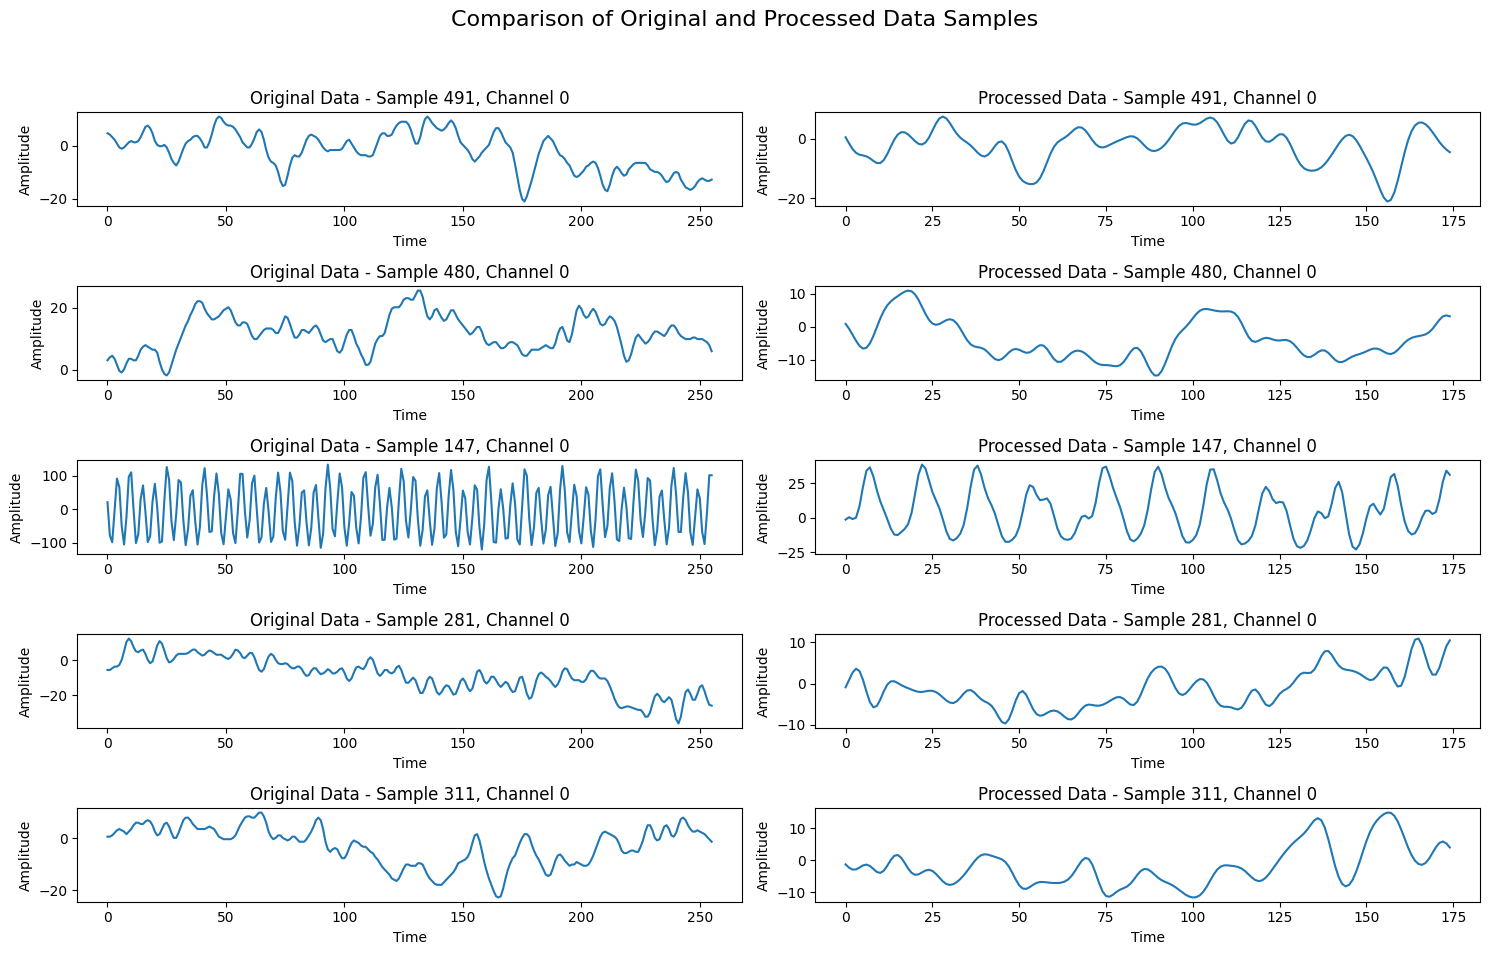

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 데이터 샘플링 및 시각화 함수
def plot_sampled_data(original_data, processed_data, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 10))
    fig.suptitle('Comparison of Original and Processed Data Samples', fontsize=16)

    # 무작위 샘플 선택
    sample_indices = random.sample(range(original_data.shape[0]), num_samples)

    for i, idx in enumerate(sample_indices):
        # 원본 데이터 플롯
        axes[i, 0].plot(original_data[idx, :, 0])  # 첫 번째 채널 사용
        axes[i, 0].set_title(f'Original Data - Sample {idx}, Channel 0')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Amplitude')

        # 처리된 데이터 플롯
        axes[i, 1].plot(processed_data[idx, :, 0])  # 첫 번째 채널 사용
        axes[i, 1].set_title(f'Processed Data - Sample {idx}, Channel 0')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].set_ylabel('Amplitude')

        # 데이터 통계 출력
        print(f"Sample {idx} - Channel 0 Statistics:")
        print(f"  Original Data Mean: {np.mean(original_data[idx, :, 0])}")
        print(f"  Original Data Std Dev: {np.std(original_data[idx, :, 0])}")
        print(f"  Processed Data Mean: {np.mean(processed_data[idx, :, 0])}")
        print(f"  Processed Data Std Dev: {np.std(processed_data[idx, :, 0])}")
        print("-" * 50)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 시각화 출력
plot_sampled_data(X_train, X_train_segmented)


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

def objective(trial):
    # 랜덤 포레스트 파라미터
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 200)
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 10)
    rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 20)
    rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
    random_forest = RandomForestClassifier(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # SVM 파라미터
    svm_C = trial.suggest_float("svm_C", 0.1, 10, log=True)
    svm_gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    svm = SVC(C=svm_C, gamma=svm_gamma, probability=True, random_state=42)

    # XGBoost 파라미터
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 200)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.5, log=True)
    xgb = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        random_state=42
    )

    # 앙상블 모델
    ensemble = VotingClassifier(
        estimators=[
            ("random_forest", random_forest),
            ("svm", svm),
            ("xgb", xgb)
        ],
        voting="soft"
    )

    # 크로스 밸리데이션으로 모델 평가
    score = cross_val_score(ensemble, X_train_scaled, y_train, cv=5, scoring="f1_macro", n_jobs=-1)
    return score.mean()

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-05-06 01:39:47,226] A new study created in memory with name: no-name-c68f9343-18f7-4cb3-90a0-3c8aca01e684
[I 2024-05-06 01:40:35,851] Trial 0 finished with value: 0.681481833020303 and parameters: {'rf_n_estimators': 184, 'rf_max_depth': 3, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1, 'svm_C': 4.651658020348824, 'svm_gamma': 'auto', 'xgb_n_estimators': 137, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.209374571044756}. Best is trial 0 with value: 0.681481833020303.
[I 2024-05-06 01:41:02,413] Trial 1 finished with value: 0.6947784200862819 and parameters: {'rf_n_estimators': 124, 'rf_max_depth': 6, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 8, 'svm_C': 0.2178327985971872, 'svm_gamma': 'scale', 'xgb_n_estimators': 79, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.2840612242770157}. Best is trial 1 with value: 0.6947784200862819.
[I 2024-05-06 01:42:17,188] Trial 2 finished with value: 0.6977572138728767 and parameters: {'rf_n_estimators': 185, 'rf_max_depth': 7, 'rf_m

Best trial:
  Value: 0.7034429892789984
  Params: 
    rf_n_estimators: 100
    rf_max_depth: 5
    rf_min_samples_split: 20
    rf_min_samples_leaf: 5
    svm_C: 0.10240480166366446
    svm_gamma: scale
    xgb_n_estimators: 182
    xgb_max_depth: 10
    xgb_learning_rate: 0.10636176052564264


In [ ]:
from sklearn.metrics import accuracy_score

best_rf = RandomForestClassifier(
    n_estimators=trial.params['rf_n_estimators'],
    max_depth=trial.params['rf_max_depth'],
    min_samples_split=trial.params['rf_min_samples_split'],
    min_samples_leaf=trial.params['rf_min_samples_leaf'],
    random_state=42
)
best_svm = SVC(
    C=trial.params['svm_C'],
    gamma=trial.params['svm_gamma'],
    probability=True,
    random_state=42
)
best_xgb = XGBClassifier(
    n_estimators=trial.params['xgb_n_estimators'],
    max_depth=trial.params['xgb_max_depth'],
    learning_rate=trial.params['xgb_learning_rate'],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('svm', best_svm), ('xgb', best_xgb)],
    voting='soft'
)
ensemble.fit(X_train_scaled, y_train)

# 훈련 데이터 정확도 출력
train_predictions = ensemble.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy on the train set:", train_accuracy)

Accuracy on the train set: 0.9851851851851852


In [ ]:
# 테스트 데이터 예측
test_predictions = ensemble.predict(X_test_scaled)

# 제출 파일 생성
submission_df = pd.DataFrame({
    'ID': np.arange(len(test_predictions)),
    'TARGET': test_predictions
})

# 제출 파일 저장 경로
submission_file_path = '/content/drive/MyDrive/0506_entry1.csv'
submission_df.to_csv(submission_file_path, index=False)
print('Submission file saved:', submission_file_path)

#대회 제출 0.94166

Submission file saved: /content/drive/MyDrive/0506_entry1.csv
